Contents:

1. Module Imports
2. Reading Data into the Notebook
3. Train - Valid - Test split
4. Data Pre-processing
5. Hyperparameter tuning
6. Evaluating test set accuracy with the trained model


In [130]:

import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split

%matplotlib inline

In [131]:
#Check the path to the directory where you are currently in
%pwd

'C:\\Users\\shrey\\Downloads'

In [132]:
'''Define a variable that points to this. This will let you avoid typing
the long path everytime you need to use it'''

my_path = 'C:\\Users\\shrey\\Downloads'

# II. Reading data into the notebook

In [133]:
'''We will use the Titanic dataset, as supplied here (Titanic_full.csv).
The same dataset can be downloaded from the Kaggle website. Check the
shape and header of the data you just read in as a dataframe. The use of
f and {} is specific to the recent versions of Python (3.x). You can as 
well type the full path here, and that works too!'''

my_df = pd.read_csv(f'{my_path}/Iris.csv')
print(my_df.shape)
my_df.head(3)

(150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa


# III. Train - Valid- Test Split

In [149]:
'''As we have seen, it's important to avoid the Texas sharp shooter logical
fallacy. So, we plit the data into three sets in a 70-15-15 manner. 
This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into 
evaluating model performance as you manually change or set the model 
hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). 
This dataset is sometimes called a holdout set or the validation set. 
Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning. After
hyperparameter tuning and model selection, which we will discuss later,
the model's final performance before sneidng it to production, will be
evalauted on this test data set.
The way the datarows are distributed will depend on the type of problem. 
Here, assuming the datarows of my_df are randomly arranged, and there's
no time component, we will simply simply do the split, using a split 
function that we define. Also, this 15% split 
for the test set may change, if the actual test set size is predefined. 
In any case we will make sure the test set we choose from our dataset 
is as similar as it can get to the actual data that it will see in 
production'''

#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,130)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(130, 6) (20, 6)


# IV. Data Pre-processing

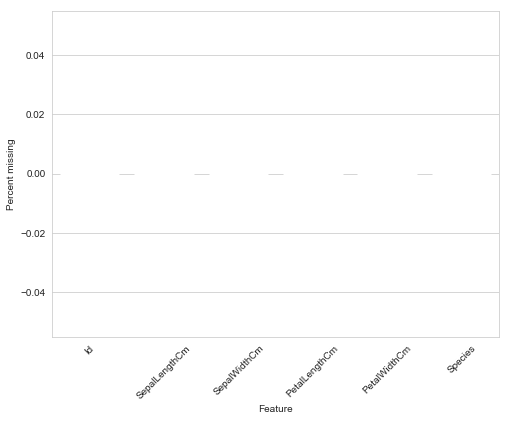

In [150]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

From the above plot, it looks like Cabin has ~80%missing values.
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute age (which has ~ 20% missing, but we'll try to impute),
Fare, and Embarked column.These have very little missing values

We are going to preprocess this dataset in these steps--

1. Convert the entire dataframe to an array of numbers. This itself is going to happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.

3. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


In [151]:
mydf_train_valid_2 = mydf_train_valid.drop("Id",axis = 1) #dropping Id coz its not required
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(130, 5)


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [137]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
SepalLengthCm    110 non-null float64
SepalWidthCm     110 non-null float64
PetalLengthCm    110 non-null float64
PetalWidthCm     110 non-null float64
Species          110 non-null object
dtypes: float64(4), object(1)
memory usage: 4.4+ KB


In [152]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers'''
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [153]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
print()

In [140]:
#Check dtypes of columns after this operation
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
SepalLengthCm    110 non-null float64
SepalWidthCm     110 non-null float64
PetalLengthCm    110 non-null float64
PetalWidthCm     110 non-null float64
Species          110 non-null category
dtypes: category(1), float64(4)
memory usage: 3.7 KB


In [154]:
'''Check the cateogry mapping for Species column. We need this
later'''
print(mydf_train_valid_3.Species.cat.categories)


Index(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype='object')


All object categories have been converted to
Category dtype !

In [155]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [156]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [144]:
mydf_train_valid_4.head(3)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1


In [20]:
'''Please store the null_table, category mapping separately.
We will need to process the test dataset using these values'''
my_table

{}

In [157]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_valid_4["Species"]
X = mydf_train_valid_4.drop(["Species"],axis = 1)

print(X.shape,Y.shape)

(130, 4) (130,)


In [146]:
'''Note that the different continuous variable columns of this dataframe 
have numbers in different ranges. For example, the Fare and age columns. 
For some machine learning algorithms like Decision Trees and 
their ensembles (Random Forests, for example) the above X and Y
can be directly used as input. However, for a lot of other ML algorithms 
like K nearest neighbors (KNN), we need to scale the continuous variables 
so that their values are mapped to a number between 0 and 1. 
Let's split this dataframe into continuous variable 
columns and those with categorical variables. We will leave 
the categorical variables untouched because their 
values are treated as different levels and its kind of meaningless to
scale them'''

#X_cat = X[['Species']] #Not applied because Species category is already dropped, No more categories is made
#X_con = X.drop(X_cat,axis = 1)
#print(X_cat.shape,X_con.shape)

"Note that the different continuous variable columns of this dataframe \nhave numbers in different ranges. For example, the Fare and age columns. \nFor some machine learning algorithms like Decision Trees and \ntheir ensembles (Random Forests, for example) the above X and Y\ncan be directly used as input. However, for a lot of other ML algorithms \nlike K nearest neighbors (KNN), we need to scale the continuous variables \nso that their values are mapped to a number between 0 and 1. \nLet's split this dataframe into continuous variable \ncolumns and those with categorical variables. We will leave \nthe categorical variables untouched because their \nvalues are treated as different levels and its kind of meaningless to\nscale them"

In [147]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''
#No standardisation is required becuase none of the columns have null values
#scaler = preprocessing.StandardScaler().fit(X)
#X_con_sc = pd.DataFrame(scaler.transform(X))
#X_con_sc.columns = ["SepalWidthCm"]

#print(X_con_sc.shape)
#X_con_sc.head(1)

"Scale the continuous variables. To standardize (includes scaling), \nwe subtract mean of that column from every value, then divide the results \nby the variable's standard deviation. There are different ways to \nstandardize. Please see preprocessing under scikit-leanr page"

In [148]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

#df_list = [X_cat,X_con_sc]
#X_full = pd.concat(df_list,axis = 1)
#print(X_full.shape)
#X_full.head(2)

"Store this scaler variable or its mean and SD, by pickling or something;\nwe need to use the same mean and SD scaler later while pre-processing \nthe test set. Now, let's join the cateogrical and scaled continuous \nvariables, back together into one dataframe"

In [158]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X,110)
Y_train,Y_valid = mydf_splitter(Y,110)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(110, 4) (20, 4) (110,) (20,)


In [159]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)
print()

In [31]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


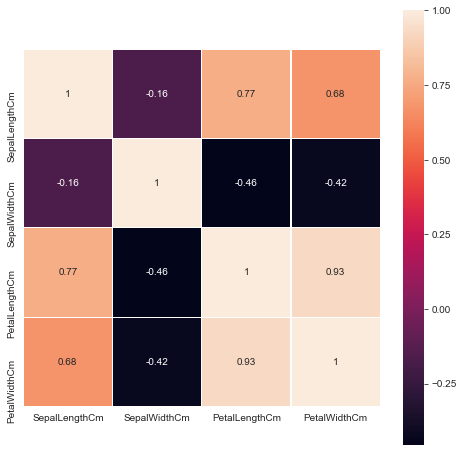

In [160]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(X.astype(int).corr(), linewidths=0.1, square=True, linecolor='white', annot=True)

#sns.heatmap(my_knn_df, xticklabels = ["Species","SepalLengthCm","SepalWidthCm" ,"PetalLengthCm","PetalWidthCm"],
 #           yticklabels = ["Species","SepalLengthCm","SepalWidthCm" ,"PetalLengthCm","PetalWidthCm"],annot = True)

In [161]:
print(accuracy_score(Y_valid,Y_pred))

0.6


# V. Hyperparameter tuning

In [162]:
'''We chose a value of K = 5 here. But how do we know if that's the right 
value? We need to do hyper parameter tuning.That is, we need to check 
different values of K and find out performance scores for each on the 
validation set! We will pick the value of K that gives the best 
validation set accuracy and use that value of K to predict on the
test set, which we have kept aside'''

from sklearn.metrics import accuracy_score

num_neighs = list()
accuracy_list = list()


for neighbor in range(1,7):
    my_knn_model = KNeighborsClassifier(n_neighbors = neighbor,weights = 'uniform')
    my_knn_model.fit(X_train,Y_train)
    Y_pred = my_knn_model.predict(X_valid)
    accuracy = accuracy_score(Y_valid,Y_pred)
    num_neighs.append(neighbor)
    accuracy_list.append(accuracy)



In [163]:
eval_df =  pd.DataFrame({"Num of neighbors": num_neighs,"Valid accuracy Score": accuracy_list})
eval_df

,Num of neighbors,Valid accuracy Score
0,1,0.75
1,2,0.55
2,3,0.55
3,4,0.55
4,5,0.60
5,6,0.55


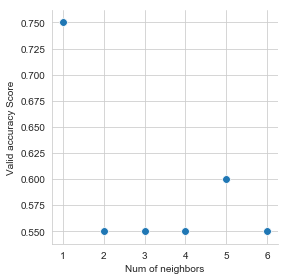

In [164]:
#Plot accuracy Vs validation set accuracy of the model
sns.set_style("whitegrid")
sns.pairplot(eval_df,x_vars = "Num of neighbors",
             y_vars = "Valid accuracy Score",plot_kws = {'s': 60},height = 4.0)

In [166]:
'''Congrats, K = 14 seems to give the best validation set accuracy (= 0.6) !!! So, let's turn to the test set
and use K = 14 for that !OK, so how do we save this trained and 
hyperparameter tuned model for later use? First, we club together, the
train and valid set. We already have this dataframe. Then, we make and 
train a model with K = 14. Then save it with joblib, which we imported 
earlier'''


knn_model_fin = KNeighborsClassifier(n_neighbors = 7,weights = 'uniform')
knn_model_fin.fit(X,Y)

%mkdir knn_model_newww
knn_model_name = f'{my_path}/knn_model/knn_model_finalnew.sav'
joblib.dump(knn_model_fin,knn_model_name)

['C:\\Users\\shrey\\Downloads/knn_model/knn_model_finalnew.sav']

In [167]:
#Make sure your model has been saved !
%ls knn_model_newww

 Volume in drive C is OS
 Volume Serial Number is 4EB0-3F77

 Directory of C:\Users\shrey\Downloads\knn_model_newww

06/15/2019  10:03 PM    <DIR>          .
06/15/2019  10:03 PM    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  116,054,786,048 bytes free


In [168]:
# Congrats! You have saved your model!Now, let's read it back in!
knn_model_loaded = joblib.load(knn_model_name)

# VI. Evaluating test set accuracy with the trained model

In [169]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)


(20, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
130,131,7.4,2.8,6.1,1.9,Iris-virginica
131,132,7.9,3.8,6.4,2.0,Iris-virginica
132,133,6.4,2.8,5.6,2.2,Iris-virginica


In [170]:
#get rid of the "Id" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Id",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(20, 5)


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
130,7.4,2.8,6.1,1.9,Iris-virginica
131,7.9,3.8,6.4,2.0,Iris-virginica
132,6.4,2.8,5.6,2.2,Iris-virginica


In [171]:
'''Make sure the category codes for train and test sets are the same as 
the ones we used previously! Here, we have coded, Name, Sex, Ticket and 
embarked. Because Name and Ticket ids will not be repeated, 
we will check Sex and embarked. Checking category codes for the test set...'''

mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Species.cat.categories

Index(['Iris-virginica'], dtype='object')

In [172]:
#Check for the Species column
mydf_test2.Species.cat.categories

Index(['Iris-virginica'], dtype='object')

In [173]:
#Cool, this means the category codes are the same. We can proceed.
#Make sure you use the same impute values of median.
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(20, 5)


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
130,7.4,2.8,6.1,1.9,1
131,7.9,3.8,6.4,2.0,1
132,6.4,2.8,5.6,2.2,1


In [83]:
my_table1

{}

In [174]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!


Y_t = mydf_test3["Species"]
X_t = mydf_test3.drop(["Species"],axis = 1)

print(X_t.shape,Y_t.shape)

(20, 4) (20,)


In [111]:
#Separate continuous and categorical variables/columns for scaling

#X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
 #      'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
#X_con_t = X_t.drop(X_cat_t,axis = 1)
#print(X_cat_t.shape,X_con_t.shape)

In [112]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

#X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
#X_con_sct.columns = ["Age","Fare"]
#print(X_con_sct.shape)
#X_con_sct.head(2)


'Scale using the training set mean and SD. This is already captured in\nthe scaler object we made. Else, save that in a joblib dump too to reload'

In [113]:
#print(X_cat_t.shape,X_con_sct.shape)

In [114]:
#Re-index before merging
#X_cat_t.reset_index(inplace = True,drop = False)

In [115]:
#X_cat_t.head()

In [116]:
#X_cat_t.drop("index",inplace = True,axis = 1)
#X_cat_t.head(2)

In [175]:
#Merge the two sets of columns
#df_list_I = [X_cat_t,X_con_sct]
#X_test_I = pd.concat(df_list_I,axis = 1)
#print(X_test_I.shape)
X_t.shape

(20, 4)

In [190]:
#Now we are ready to test it out. Let's load the saved model first.
kNN_loaded = joblib.load(f'{my_path}/knn_model/knn_model_finalnew.sav')

In [191]:
Y_test_pred = kNN_loaded.predict(X_t)

In [192]:
print(accuracy_score(Y_t,Y_test_pred))

0.0
